In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'buckeye'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
??HParams

In [8]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=100,
    mel_upper_edge_hertz=7998,
    butter_lowcut = 100,
    butter_highcut = 7998,
    ref_level_db = 20,
    min_level_db = -50,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 0.5,
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.0s


[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:    6.8s finished


In [10]:
dataset.sample_json

OrderedDict([('species', 'Homo sapien'),
             ('age', 'o'),
             ('sex', 'f'),
             ('common_name', 'Human'),
             ('samplerate_hz', 16000),
             ('length_s', 564.33),
             ('wav_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/buckeye/2019-10-08_21-32-02/WAV/s2501b.WAV'),
             ('indvs',
              OrderedDict([('s25',
                            OrderedDict([('words',
                                          OrderedDict([('start_times',
                                                        [24.457298,
                                                         24.722471,
                                                         24.900012,
                                                         25.121935,
                                                         25.58944,
                                                         25.778605,
                                                    

In [11]:
n_jobs = -1
verbosity=1

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[
                "labels",
                "word",
                "utterance_number",
                "position_in_utterance",
                "position_in_word",
                "word_number",
            ],
            unit="phones",
            dict_features_to_retain=["age", "sex"],
            key=key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   18.4s


[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:   29.7s finished


837896

In [13]:
syllable_df[:5]

,start_time,end_time,labels,word,utterance_number,position_in_utterance,position_in_word,word_number,indv,indvi,age,sex,key
0,24.457298,24.722471,ah,uh,0,0,0,0,s25,0,o,f,s2501b
1,24.722471,24.792000,ih,it's,1,1,0,1,s25,0,o,f,s2501b
2,24.792000,24.847660,t,it's,2,1,1,1,s25,0,o,f,s2501b
3,24.847660,24.900012,s,it's,3,1,2,1,s25,0,o,f,s2501b
4,24.900012,25.070721,ao,all,4,2,0,2,s25,0,o,f,s2501b


In [14]:
word_beginnings = list(np.where(list(syllable_df.position_in_word == 0))[0])
len(word_beginnings)

283697

In [15]:
word_endings = list(np.where(list(syllable_df.position_in_word[1:] == 0))[0]) + [len(syllable_df)]
len(word_endings)

283697

In [16]:
word_beginnings[:3], word_endings[:3]

([0, 1, 4], [0, 3, 5])

### make dataframe of words comprised of phones

In [21]:
def make_word_row(word_df, surrounding_context_s=0.0):
    row = word_df.iloc[0]
    start_time = word_df.start_time.values[0] - surrounding_context_s
    return [
        start_time,
        word_df.end_time.values[-1] + surrounding_context_s,
        row.word,
        list(word_df.labels),
        np.array(list(word_df.start_time)) - start_time,
        np.array(list(word_df.end_time)) - start_time,
        row.utterance_number,
        row.position_in_utterance,
        row.word_number,
        row.indv,
        row.indvi,
        row.age,
        row.sex,
        row.key,
    ]

In [22]:
with Parallel(n_jobs=1, verbose=verbosity) as parallel:
    words_df = parallel(
        delayed(make_word_row)(syllable_df[wb : we + 1])
        for wb, we in tqdm(zip(word_beginnings, word_endings), total=len(word_beginnings))
    )
words_df = pd.DataFrame(words_df, 
    columns=[
        "start_time",
        "end_time",
        "word",
        "phones",
        "phone_start_times",
        "phone_end_times",
        "utterance_number",
        "position_in_utterance",
        "word_number",
        "indv",
        "indvi",
        "age",
        "sex",
        "key",
    ]
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 283697 out of 283697 | elapsed:  7.6min finished


In [23]:
words_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key
0,24.457298,24.722471,uh,[ah],[0.0],[0.2651729999999972],0,0,0,s25,0,o,f,s2501b
1,24.722471,24.900012,it's,"[ih, t, s]","[0.0, 0.06952900000000284, 0.12518900000000244]","[0.06952900000000284, 0.12518900000000244, 0.1...",1,1,1,s25,0,o,f,s2501b
2,24.900012,25.121935,all,"[ao, l]","[0.0, 0.17070899999999867]","[0.17070899999999867, 0.22192300000000031]",4,2,2,s25,0,o,f,s2501b


### get audio for dataset

In [24]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    word_df = parallel(
        delayed(get_row_audio)(
            words_df[words_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(words_df.key.unique())
    )
word_df = pd.concat(word_df)
len(word_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 254 out of 254 | elapsed:  1.2min finished


283697

In [25]:
word_df[:10]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,audio,rate
0,24.457298,24.722471,uh,[ah],[0.0],[0.2651729999999972],0,0,0,s25,0,o,f,s2501b,"[0.00076912943, 0.0005121703, 0.00023888524, 3...",16000
1,24.722471,24.900012,it's,"[ih, t, s]","[0.0, 0.06952900000000284, 0.12518900000000244]","[0.06952900000000284, 0.12518900000000244, 0.1...",1,1,1,s25,0,o,f,s2501b,"[0.059271634, 0.057913125, 0.054260213, 0.0520...",16000
2,24.900012,25.121935,all,"[ao, l]","[0.0, 0.17070899999999867]","[0.17070899999999867, 0.22192300000000031]",4,2,2,s25,0,o,f,s2501b,"[0.02202918, 0.0062374687, 0.0076014344, 0.010...",16000
3,25.121935,25.588546,over,"[ow, v, er, hh]","[0.0, 0.11835999999999913, 0.1855070000000012,...","[0.11835999999999913, 0.1855070000000012, 0.33...",6,3,3,s25,0,o,f,s2501b,"[0.019947302, 0.018965548, 0.01890934, 0.01893...",16000
4,25.588546,25.778605,they,"[dh, ey]","[0.0, 0.06714699999999851]","[0.06714699999999851, 0.19005899999999798]",10,4,4,s25,0,o,f,s2501b,"[-0.0046628322, -0.0048877206, -0.0050200713, ...",16000
5,25.778605,26.286187,contract,"[k, aa, n, d, r, ae, k]","[0.0, 0.14339500000000172, 0.22761700000000218...","[0.14339500000000172, 0.22761700000000218, 0.2...",12,5,5,s25,0,o,f,s2501b,"[0.0039654337, 0.003324886, 0.0029010815, 0.00...",16000
6,26.286187,26.492180,with,"[t, w, ah, th]","[0.0, 0.04324699999999737, 0.08581299999999814...","[0.04324699999999737, 0.08581299999999814, 0.1...",19,6,6,s25,0,o,f,s2501b,"[0.0005586573, 0.0004337812, 0.0005070349, 0.0...",16000
7,26.492180,26.941719,dominion,"[d, ih, m, ih, n, y, ih, n]","[0.0, 0.07283699999999982, 0.11981999999999715...","[0.07283699999999982, 0.11981999999999715, 0.1...",23,7,7,s25,0,o,f,s2501b,"[-0.00090890797, -0.0011107079, -0.0010968347,...",16000
8,26.941719,27.462000,homes,"[hh, ow, m, s]","[0.0, 0.05462800000000101, 0.2424110000000006,...","[0.05462800000000101, 0.2424110000000006, 0.39...",31,8,8,s25,0,o,f,s2501b,"[-0.009664764, -0.010353056, -0.010768147, -0....",16000
9,27.788663,27.909083,and,"[eh, n]","[0.0, 0.07034399999999863]","[0.07034399999999863, 0.1204199999999993]",35,10,10,s25,0,o,f,s2501b,"[-4.5462413e-05, 0.00021854062, 0.0006603711, ...",16000


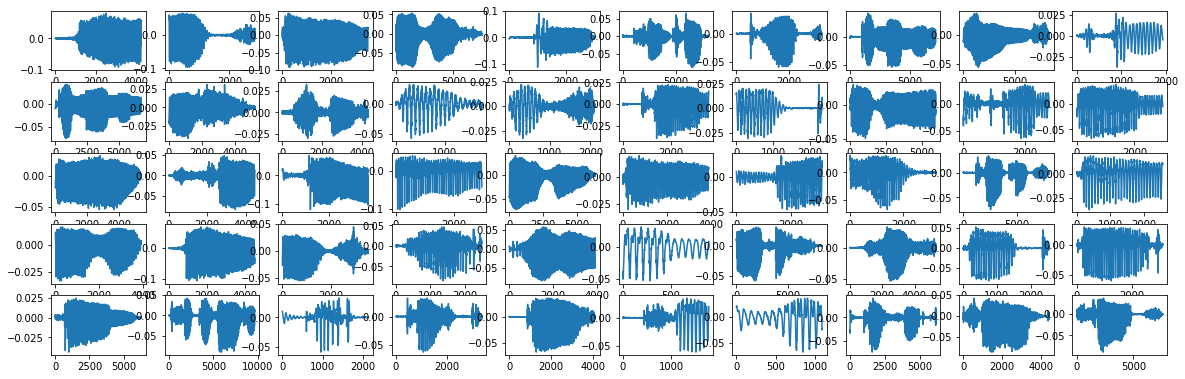

In [26]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(word_df[:nrows*ncols].audio.values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [27]:
syll_lens = np.array([len(i) for i in tqdm(word_df.audio.values)])
word_df = word_df[(syll_lens > 100)& (syll_lens < 20000)]
syll_lens = np.array([len(i) for i in tqdm(word_df.audio.values)])

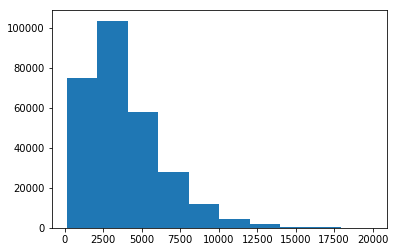

In [28]:
plt.hist(syll_lens);

In [29]:
len(word_df)

283533

In [30]:
word_df['audio'] = [i/np.max(np.abs(i)) for i in tqdm(word_df.audio.values)]

### Create spectrograms

In [31]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [ ]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(word_df['audio'].values, word_df['rate'].values),
            total=len(word_df),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 912 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 3912 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 8112 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 13512 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 20112 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 27912 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 36912 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 47112 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 58512 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 71112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 84912 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 99912 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 116112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1335

In [ ]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]

In [ ]:
nrows = 8
ncols = 8
zoom = 4
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows*zoom/1.5))
for i, syll in tqdm(enumerate(syllables_spec[:nrows*ncols]), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.matshow(syll, aspect='auto', interpolation=None)
    ax.axis('off')

In [ ]:
word_lens_t = [np.shape(i)[1] for i in syllables_spec]
plt.hist(word_lens_t);

In [ ]:
word_df['spectrogram'] = syllables_spec

In [ ]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'words_full_length.pickle'
ensure_dir(save_loc)
word_df.drop(['audio'], axis=1).to_pickle(save_loc)